In [1]:
# %load task_relation_extraction.py
# 三元组抽取任务，基于“半指针-半标注”结构
# 文章介绍：https://kexue.fm/archives/7161
# 数据集：http://ai.baidu.com/broad/download?dataset=sked
# 最优f1=0.82198
# 换用RoBERTa Large可以达到f1=0.829+
# 说明：由于使用了EMA，需要跑足够多的步数(5000步以上）才生效，如果
#      你的数据总量比较少，那么请务必跑足够多的epoch数，或者去掉EMA。

import json
import numpy as np
from bert4keras.backend import keras, K, batch_gather
from bert4keras.layers import Loss
from bert4keras.layers import LayerNormalization,MultiHeadAttention,PositionEmbedding
from bert4keras.tokenizers import Tokenizer
from bert4keras.models import build_transformer_model
from bert4keras.optimizers import Adam, extend_with_exponential_moving_average
from bert4keras.snippets import sequence_padding, DataGenerator
from bert4keras.snippets import open, to_array
from keras.optimizers import Nadam
from keras.layers import *
from keras import initializers, activations
from keras.models import Model, Sequential
from tqdm.notebook import tqdm
import os
import tensorflow as tf

os.environ['TF_KERAS'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
strategy = tf.distribute.MirroredStrategy()

Using TensorFlow backend.


In [2]:
maxlen = 256
batch_size = 8
config_path = '../../chinese_L-12_H-768_A-12/bert_config.json'
checkpoint_path = '../../chinese_L-12_H-768_A-12/bert_model.ckpt'
dict_path = '../../chinese_L-12_H-768_A-12/vocab.txt'

# config_path = '../../FinBERT/bert_config.json'
# checkpoint_path = '../../FinBERT/bert_model.ckpt'
# dict_path = '../../FinBERT/vocab.txt'


# def load_data(filename):
#     """加载数据
#     单条格式：{'text': text, 'spo_list': [(s, p, o)]}
#     """
#     D = []
#     with open(filename, encoding='utf-8') as f:
#         for l in f:
#             l = json.loads(l)
#             D.append({
#                 'text': l['text'],
#                 'spo_list': [(spo['subject'], spo['predicate'], spo['object'])
#                              for spo in l['spo_list']]
#             })
#     return D

def load_data(filename):
    D = []
    with open(filename, encoding='utf-8') as f:
        for l in f:
            l = json.loads(l)
            for line in l:
                D.append({
                    'text':line['text'],
                    'spo_list':[(spo[0],spo[1],spo[2])
                                for spo in line['spo_list']]
                })
    return D

print('loading data...')

train_data = load_data('../../datasets/finance/train_data.json')
valid_data = load_data('../../datasets/finance/dev_data.json')
predicate2id, id2predicate = {}, {}

with open('../../datasets/finance/all_5_schemas') as f:
    for l in f:
        l = json.loads(l)
        if l['predicate'] not in predicate2id:
            id2predicate[len(predicate2id)] = l['predicate']
            predicate2id[l['predicate']] = len(predicate2id)

# 加载数据集
# train_data = load_data('../../datasets/Cooperate/train_coo_data.json')
# valid_data = load_data('../../datasets/Cooperate/dev_coo_data.json')
# predicate2id, id2predicate = {}, {}

# with open('../../datasets/Cooperate/all_schemas') as f:
#     for l in f:
#         l = json.loads(l)
#         if l['predicate'] not in predicate2id:
#             id2predicate[len(predicate2id)] = l['predicate']
#             predicate2id[l['predicate']] = len(predicate2id)

# 建立分词器
tokenizer = Tokenizer(dict_path, do_lower_case=True)


def search(pattern, sequence):
    """从sequence中寻找子串pattern
    如果找到，返回第一个下标；否则返回-1。
    """
    n = len(pattern)
    for i in range(len(sequence)):
        if sequence[i:i + n] == pattern:
            return i
    return -1


class data_generator(DataGenerator):
    """数据生成器
    """
    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids = [], []
        batch_subject_labels, batch_subject_ids, batch_object_labels = [], [], []
        for is_end, d in self.sample(random):
            token_ids, segment_ids = tokenizer.encode(d['text'], maxlen=maxlen)
            # 整理三元组 {s: [(o, p)]}
            spoes = {}
            for s, p, o in d['spo_list']:
                s = tokenizer.encode(s)[0][1:-1]
                p = predicate2id[p]
                o = tokenizer.encode(o)[0][1:-1]
                s_idx = search(s, token_ids)
                o_idx = search(o, token_ids)
                if s_idx != -1 and o_idx != -1:
                    s = (s_idx, s_idx + len(s) - 1)
                    o = (o_idx, o_idx + len(o) - 1, p)
                    if s not in spoes:
                        spoes[s] = []
                    spoes[s].append(o)
            if spoes:
                # subject标签
                subject_labels = np.zeros((len(token_ids), 2))
                for s in spoes:
                    subject_labels[s[0], 0] = 1
                    subject_labels[s[1], 1] = 1
                # 随机选一个subject
                start, end = np.array(list(spoes.keys())).T
                rindex = np.random.choice(len(start))
                start = start[rindex]
                end = end[rindex]
#                 end = np.random.choice(end)
                subject_ids = (start, end)
                # 对应的object标签
                object_labels = np.zeros((len(token_ids), len(predicate2id), 2))
                for o in spoes.get(subject_ids, []):
                    object_labels[o[0], o[2], 0] = 1
                    object_labels[o[1], o[2], 1] = 1
                # 构建batch
                batch_token_ids.append(token_ids)
                batch_segment_ids.append(segment_ids)
                batch_subject_labels.append(subject_labels)
                batch_subject_ids.append(subject_ids)
                batch_object_labels.append(object_labels)
                if len(batch_token_ids) == self.batch_size or is_end:
                    batch_token_ids = sequence_padding(batch_token_ids)
                    batch_segment_ids = sequence_padding(batch_segment_ids)
                    batch_subject_labels = sequence_padding(
                        batch_subject_labels
                    )
                    batch_subject_ids = np.array(batch_subject_ids)
                    batch_object_labels = sequence_padding(batch_object_labels)
                    yield [
                        batch_token_ids, batch_segment_ids,
                        batch_subject_labels, batch_subject_ids,
                        batch_object_labels
                    ], None
                    batch_token_ids, batch_segment_ids = [], []
                    batch_subject_labels, batch_subject_ids, batch_object_labels = [], [], []


def extract_subject(inputs):
    """根据subject_ids从output中取出subject的向量表征
    """
    output, subject_ids = inputs
    start = batch_gather(output, subject_ids[:, :1])
    end = batch_gather(output, subject_ids[:, 1:])
    subject = K.concatenate([start, end], 2)
    return subject[:, 0]


# 补充输入
subject_labels = Input(shape=(None, 2), name='Subject-Labels')
subject_ids = Input(shape=(2,), name='Subject-Ids')
object_labels = Input(shape=(None, len(predicate2id), 2), name='Object-Labels')

loading data...


In [3]:
len(train_data)

790

In [4]:
class Self_Attention(Layer):
  
    def __init__(self, output_dim,kernal_initializer='uniform', **kwargs):
        self.output_dim = output_dim
        self.kernal_initializer = initializers.get(kernal_initializer)
        super(Self_Attention, self).__init__(**kwargs)
        self.supports_masking = True
  
    def build(self, input_shape):
        # 为该层创建一个可训练的权重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer=self.kernal_initializer,
                                      trainable=True)
  
        super(Self_Attention, self).build(input_shape)  # 一定要在最后调用它
  
    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
  
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
  
        QK = QK / (64**0.5)
  
        QK = K.softmax(QK)
  
        V = K.batch_dot(QK,WV)
  
        return V
  
    def compute_output_shape(self, input_shape):
  
        return (input_shape[0],input_shape[1],self.output_dim)

In [5]:
print('loading bert...')
# 加载预训练模型
bert = build_transformer_model(
    config_path=config_path,
    checkpoint_path=checkpoint_path,
    model='bert',
    return_keras_model=False,
)

output = LayerNormalization(conditional=False)(bert.model.output)
# 预测subject
output = Dense(
    units=2, activation='sigmoid', kernel_initializer=bert.initializer
)(output)
subject_preds = Lambda(lambda x: x**2)(output)

subject_model = Model(bert.model.inputs, subject_preds)

# 传入subject，预测object
# 通过Conditional Layer Normalization将subject融入到object的预测中
output = bert.model.layers[-2].get_output_at(-1)
subject = Lambda(extract_subject)([output, subject_ids])

# output = PositionEmbedding(
#     input_dim=maxlen,
#     output_dim=768,
#     merge_mode='mul',
#     embeddings_initializer=bert.initializer
# )(output)

output = Self_Attention(768)(output)
output = LayerNormalization(conditional=True)([output, subject])

# output = Self_Attention(896)(output)
print(output.shape)
output = Dense(
    units=len(predicate2id) * 2,
    activation='sigmoid',
    kernel_initializer=bert.initializer
)(output)
output = Lambda(lambda x: x**4)(output)
object_preds = Reshape((-1, len(predicate2id), 2))(output)

object_model = Model(bert.model.inputs + [subject_ids], object_preds)


class TotalLoss(Loss):
    """subject_loss与object_loss之和，都是二分类交叉熵
    """
    def compute_loss(self, inputs, mask=None):
        subject_labels, object_labels = inputs[:2]
        subject_preds, object_preds, _ = inputs[2:]
        if mask[4] is None:
            mask = 1.0
        else:
            mask = K.cast(mask[4], K.floatx())
        # sujuect部分loss
        subject_loss = K.binary_crossentropy(subject_labels, subject_preds)
        subject_loss = K.mean(subject_loss, 2)
        subject_loss = K.sum(subject_loss * mask) / K.sum(mask)
        # object部分loss
        object_loss = K.binary_crossentropy(object_labels, object_preds)
        object_loss = K.sum(K.mean(object_loss, 3), 2)
        object_loss = K.sum(object_loss * mask) / K.sum(mask)
        # 总的loss
        return subject_loss + object_loss


subject_preds, object_preds = TotalLoss([2, 3])([
    subject_labels, object_labels, subject_preds, object_preds,
    bert.model.output
])

# AdamEMA = extend_with_exponential_moving_average(Adam, name='AdamEMA')
# optimizer = AdamEMA(learning_rate=1e-5)
# 训练模型 
optimizer = Adam(learning_rate=1e-5)


print('start training...')

with strategy.scope():
    train_model = Model(
        bert.model.inputs + [subject_labels, subject_ids, object_labels],
        [subject_preds, object_preds]
    )
    train_model.compile(optimizer=optimizer, metrics=['acc'])


def extract_spoes(text):
    """抽取输入text所包含的三元组
    """
    tokens = tokenizer.tokenize(text, maxlen=maxlen)
    mapping = tokenizer.rematch(text, tokens)
    token_ids, segment_ids = tokenizer.encode(text, maxlen=maxlen)
    token_ids, segment_ids = to_array([token_ids], [segment_ids])
    # 抽取subject
    subject_preds = subject_model.predict([token_ids, segment_ids])
    start = np.where(subject_preds[0, :, 0] > 0.6)[0]
    end = np.where(subject_preds[0, :, 1] > 0.5)[0]
    subjects = []
    for i in start:
        j = end[end >= i]
        if len(j) > 0:
            j = j[0]
            subjects.append((i, j))
    if subjects:
        spoes = []
        token_ids = np.repeat(token_ids, len(subjects), 0)
        segment_ids = np.repeat(segment_ids, len(subjects), 0)
        subjects = np.array(subjects)
        # 传入subject，抽取object和predicate
        object_preds = object_model.predict([token_ids, segment_ids, subjects])
        for subject, object_pred in zip(subjects, object_preds):
            start = np.where(object_pred[:, :, 0] > 0.6)
            end = np.where(object_pred[:, :, 1] > 0.5)
            for _start, predicate1 in zip(*start):
                for _end, predicate2 in zip(*end):
                    if _start <= _end and predicate1 == predicate2:
                        spoes.append(
                            ((mapping[subject[0]][0],
                              mapping[subject[1]][-1]), predicate1,
                             (mapping[_start][0], mapping[_end][-1]))
                        )
                        break
        return [(text[s[0]:s[1] + 1], id2predicate[p], text[o[0]:o[1] + 1])
                for s, p, o, in spoes]
    else:
        return []


class SPO(tuple):
    """用来存三元组的类
    表现跟tuple基本一致，只是重写了 __hash__ 和 __eq__ 方法，
    使得在判断两个三元组是否等价时容错性更好。
    """
    def __init__(self, spo):
        self.spox = (
            tuple(tokenizer.tokenize(spo[0])),
            spo[1],
            tuple(tokenizer.tokenize(spo[2])),
        )

    def __hash__(self):
        return self.spox.__hash__()

    def __eq__(self, spo):
        return self.spox == spo.spox

f1_process = []
ac_process = []
rc_process = []
def evaluate(data):
    """评估函数，计算f1、precision、recall
    """
    X, Y, Z = 1e-10, 1e-10, 1e-10
    f = open('dev_pred.json', 'w', encoding='utf-8')
#     pbar = tqdm(data)
    for d in data:
        R = set([SPO(spo) for spo in extract_spoes(d['text'])])
        T = set([SPO(spo) for spo in d['spo_list']])
        X += len(R & T)
        Y += len(R)
        Z += len(T)
        f1, precision, recall = 2 * X / (Y + Z), X / Y, X / Z
#         pbar.update()
#         pbar.set_description(
#             'f1: %.5f, precision: %.5f, recall: %.5f' % (f1, precision, recall)
#         )
        s = json.dumps({
            'text': d['text'],
            'spo_list': list(T),
            'spo_list_pred': list(R),
            'new': list(R - T),
            'lack': list(T - R),
        },
                       ensure_ascii=False,
                       indent=4)
        f.write(s + '\n')
#     pbar.close()
    f1_process.append(f1)
    ac_process.append(precision)
    rc_process.append(recall)
    f.close()
    return f1, precision, recall


class Evaluator(keras.callbacks.Callback):
    """评估与保存
    """
    def __init__(self):
        self.best_val_f1 = 0.

    def on_epoch_end(self, epoch, logs=None):
#         optimizer.apply_ema_weights()
        f1, precision, recall = evaluate(valid_data)
        if f1 >= self.best_val_f1:
            self.best_val_f1 = f1
            train_model.save_weights('best_model.weights')
#         optimizer.reset_old_weights()
        print(
            'f1: %.5f, precision: %.5f, recall: %.5f, best f1: %.5f\n' %
            (f1, precision, recall, self.best_val_f1)        )

loading bert...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, ?, 768)
start training...


/opt/conda/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output total_loss_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to total_loss_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [6]:
# %%capture capt
if __name__ == '__main__':

    train_generator = data_generator(train_data, batch_size)
    evaluator = Evaluator()

    train_model.fit_generator(
        train_generator.forfit(),
        steps_per_epoch=len(train_generator),
        epochs=50,
        callbacks=[evaluator]
    )

else:

    train_model.load_weights('best_model.weights')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
99/99 [==============================] - 117s 1s/step - loss: 0.1680
f1: 0.00000, precision: 1.00000, recall: 0.00000, best f1: 0.00000

Epoch 2/50
99/99 [==============================] - 97s 978ms/step - loss: 0.0778
f1: 0.00000, precision: 1.00000, recall: 0.00000, best f1: 0.00000

Epoch 3/50
99/99 [==============================] - 98s 990ms/step - loss: 0.0524
f1: 0.14953, precision: 0.88889, recall: 0.08163, best f1: 0.14953

Epoch 4/50
99/99 [==============================] - 100s 1s/step - loss: 0.0412
f1: 0.35573, precision: 0.78947, recall: 0.22959, best f1: 0.35573

Epoch 5/50
99/99 [==============================] - 98s 992ms/step - loss: 0.0328
f1: 0.45993, precision: 0.72527, recall: 0.33673, best f1: 0.45993

Epoch 6/50
99/99 [==============================] - 99s 1s/step - loss: 0.0261
f1: 0.56140, precision: 0.65753, recall: 0.48980, best f1: 0.56140

Epoch 7/50


KeyboardInterrupt: 

In [7]:
def evaluate(data):
    """评估函数，计算f1、precision、recall
    """
    X, Y, Z = 1e-10, 1e-10, 1e-10
    f = open('coo-valid.json', 'w', encoding='utf-8')
    pbar = tqdm(data)
    for d in pbar:
        R = set([SPO(spo) for spo in extract_spoes(d['text'])])
        T = set([SPO(spo) for spo in d['spo_list']])
        X += len(R & T)
        Y += len(R)
        Z += len(T)
        f1, precision, recall = 2 * X / (Y + Z), X / Y, X / Z
        pbar.update()
        pbar.set_description(
            'f1: %.5f, precision: %.5f, recall: %.5f' % (f1, precision, recall)
        )
        s = json.dumps({
            'text': d['text'],
            'spo_list': list(T),
            'spo_list_pred': list(R),
            'new': list(R - T),
            'lack': list(T - R),
        },
                       ensure_ascii=False,
                       indent=4)
        f.write(s + '\n')
    pbar.close()
    f.close()
train_model.load_weights('best_model.weights')
evaluate(load_data('coo-test.json'))

In [10]:
def predict(text):
    R = set([SPO(spo) for spo in extract_spoes(text)])
    print(list(R))
test = "诺力股份(603611)5月30日晚间公告，近日，公司全资子公司中鼎集成与福鼎时代签订了多份合同，合同内容为中鼎集成向宁德时代提供自动化成测试物流系统，合同总金额为2.29亿元。"
train_model.load_weights('best_model.weights')
predict(test)

[('中鼎集成', '合作', '福鼎时代'), ('诺力股份', '合作', '福鼎时代')]


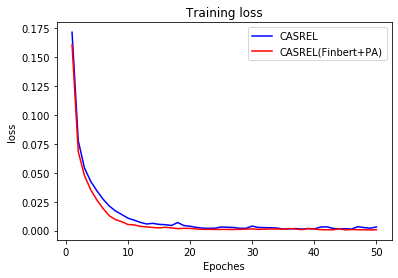

In [31]:
import matplotlib.pyplot as plt
history_dict = train_model.history.history

loss_values = history_dict['loss']
epoches = range(1, len(loss_values)+1)

plt.plot(epoches, loss_base, 'b', label='CASREL')
plt.plot(epoches, loss_values, 'r', label='CASREL(Finbert+PA)')
plt.title('Training loss')
plt.xlabel('Epoches')
plt.ylabel('loss')
plt.legend()
plt.show()

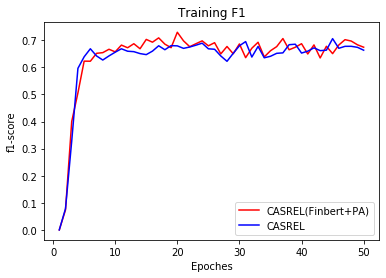

In [17]:
import matplotlib.pyplot as plt

epoches = range(1, len(f1_base)+1)

plt.plot(epoches, f1_base, 'r', label= 'CASREL(Finbert+PA)')
plt.plot(epoches, f1_process, 'b', label='CASREL')
plt.title('Training F1')
plt.xlabel('Epoches')
plt.ylabel('f1-score')
plt.legend()
plt.show()

In [7]:
train_model.history.history

{'loss': [0.17166571089199611,
  0.07775809790406908,
  0.05417341708072594,
  0.04271568655967713,
  0.034463592405830114,
  0.027187801195042473,
  0.0212922110834292,
  0.016982917987874577,
  0.01398470652954919,
  0.010804510518376316,
  0.009096475203654596,
  0.007163843021595053,
  0.005766893454960414,
  0.006312145952667509,
  0.005444311709808452,
  0.005170059695041605,
  0.0044720797347170965,
  0.007011276397055813,
  0.004444620848101165,
  0.0038185534752639277,
  0.0028337416940900895,
  0.002188741492905787,
  0.0019949889312764362,
  0.0021034846825724735,
  0.0031441671451154563,
  0.0029559845819936265,
  0.002755791589152068,
  0.0020649109281865616,
  0.0020277780158046103,
  0.003927053745303835,
  0.002771551710486944,
  0.0026249772902312025,
  0.002498515366210735,
  0.0022265660796048385,
  0.0014338943348931414,
  0.0015369312048590343,
  0.0018241328446726714,
  0.0013695291027293673,
  0.0018221903200693695,
  0.0015110892651968503,
  0.003110434292050610

In [32]:
f1_process =[1.0989010988998915e-12,
 0.13333333333422223,
 0.4461538461542722,
 0.5333333333336608,
 0.5937500000002539,
 0.5827338129499405,
 0.6843657817111007,
 0.6776859504134007,
 0.6543209876545344,
 0.7041420118344947,
 0.7009063444110569,
 0.6763848396503346,
 0.6846846846848741,
 0.6462395543177459,
 0.6685878962537933,
 0.6404494382024493,
 0.6847826086958235,
 0.6536312849163947,
 0.6610644257704981,
 0.6607669616521176,
 0.6345609065157879,
 0.6720430107528645,
 0.7028571428573127,
 0.6721311475411629,
 0.6576819407009932,
 0.6834733893559197,
 0.6906077348068008,
 0.6626865671643806,
 0.6759002770084899,
 0.6887052341599512,
 0.7107857142858844,
 0.6723646723648591,
 0.6703601108035068,
 0.650666666666853,
 0.6744868035192526,
 0.6483180428136708,
 0.6646884272999023,
 0.6510263929620815,
 0.6521739130436673,
 0.6385542168676877,
 0.6646706586828356,
 0.6611111111112994,
 0.6475644699142421,
 0.6627906976746147,
 0.6726726726728693,
 0.6687697160885371,
 0.6494252873565234,
 0.6885245901641047,
 0.6552706552708517,
 0.687861271676481]

In [30]:
loss_base=[0.17166571089199611,
  0.07775809790406908,
  0.05417341708072594,
  0.04271568655967713,
  0.034463592405830114,
  0.027187801195042473,
  0.0212922110834292,
  0.016982917987874577,
  0.01398470652954919,
  0.010804510518376316,
  0.009096475203654596,
  0.007163843021595053,
  0.005766893454960414,
  0.006312145952667509,
  0.005444311709808452,
  0.005170059695041605,
  0.0044720797347170965,
  0.007011276397055813,
  0.004444620848101165,
  0.0038185534752639277,
  0.0028337416940900895,
  0.002188741492905787,
  0.0019949889312764362,
  0.0021034846825724735,
  0.0031441671451154563,
  0.0029559845819936265,
  0.002755791589152068,
  0.0020649109281865616,
  0.0020277780158046103,
  0.003927053745303835,
  0.002771551710486944,
  0.0026249772902312025,
  0.002498515366210735,
  0.0022265660796048385,
  0.0014338943348931414,
  0.0015369312048590343,
  0.0018241328446726714,
  0.0013695291027293673,
  0.0018221903200693695,
  0.0015110892651968503,
  0.0031104342920506107,
  0.003343839206001056,
  0.0019570106151513755,
  0.0013983187942566084,
  0.0017053382551031452,
  0.001356928202440031,
  0.0034087877269900805,
  0.0026740837676749963,
  0.00211670535076077,
  0.0031710087705869227]

In [24]:
f1_base = [1.0989010988998915e-12,
 0.0740740740750539,
 0.40000000000050007,
 0.5056603773588637,
 0.6228373702424757,
 0.6225165562916408,
 0.6516853932586227,
 0.654205607476851,
 0.6666666666668783,
 0.6571428571430531,
 0.6820809248556752,
 0.6722689075632089,
 0.6871165644173699,
 0.6685878962537933,
 0.7030303030304831,
 0.6927710843375345,
 0.7087087087088837,
 0.6855345911951664,
 0.6725146198832325,
 0.7294832826749366,
 0.697674418604827,
 0.6762177650431656,
 0.6871165644173699,
 0.697674418604827,
 0.6794520547946963,
 0.6909090909092783,
 0.6495726495728493,
 0.6769230769232758,
 0.6501377410470248,
 0.6863905325445643,
 0.635616438356364,
 0.6705539358602505,
 0.6925373134330195,
 0.6384180790962496,
 0.6611570247935752,
 0.6764705882354844,
 0.7062314540061091,
 0.6647727272729178,
 0.6742209631729892,
 0.6871508379890017,
 0.6492753623190439,
 0.6827794561935452,
 0.6346666666668616,
 0.6776859504134007,
 0.6505376344087901,
 0.6824925816025624,
 0.7020648967553381,
 0.6969696969698806,
 0.683195592286676,
 0.6742209631729892]

In [19]:
loss_values

[0.17087408528675008,
 0.062126445374156854,
 0.042556937529316434,
 0.030499104924405676,
 0.021343603541579426,
 0.014720828071991099,
 0.009815503008475031,
 0.007044392485831734,
 0.005639916057167928,
 0.00444737901746095,
 0.0036517452613650998,
 0.0038907122273658273,
 0.002672251105261377,
 0.002532007634681001,
 0.0024736531411851696,
 0.00167092290158749,
 0.0014488448720437156,
 0.001158871512441554,
 0.0015491560430124496,
 0.0013200964740347826,
 0.001469879688642023,
 0.0009987705275180596,
 0.0011298390223992447,
 0.00103304762853003,
 0.0009489012310352129,
 0.0012224671486146229,
 0.001174527559874438,
 0.0016706731660391758,
 0.0019548424274978948,
 0.0011680836819334816,
 0.0009330722344398228,
 0.0008676036621872748,
 0.001204205916301477,
 0.0012443661328355039,
 0.0008192445978572404,
 0.0010928457487180028,
 0.0009332439612414499,
 0.001220948882588875,
 0.0010523516822737477,
 0.00124594891013554,
 0.0010818826747524752,
 0.0015193706350710501,
 0.00066741258970

In [20]:
f1_process

[1.020408163264265e-12,
 0.15962441314632903,
 0.3694779116470928,
 0.5812500000002617,
 0.6491228070177492,
 0.6253521126762674,
 0.6239554317550842,
 0.6578249336871842,
 0.6869806094184561,
 0.623655913978697,
 0.6633416458854546,
 0.6867167919801069,
 0.633766233766424,
 0.6321839080461884,
 0.6649484536084201,
 0.687830687830853,
 0.67179487179504,
 0.6631853785902543,
 0.6684210526317536,
 0.6666666666668325,
 0.687830687830853,
 0.6577540106953702,
 0.6956521739132089,
 0.65760869565236,
 0.6505376344087901,
 0.6594005449593138,
 0.6629834254145509,
 0.6256410256412177,
 0.6153846153848063,
 0.6340206185568897,
 0.6437994722957026,
 0.6256157635469825,
 0.6760563380283515,
 0.6581632653062969,
 0.6414141414143225,
 0.6267029972754078,
 0.6684782608697455,
 0.6456692913387687,
 0.6232294617565874,
 0.6774193548388832,
 0.5955555555557352,
 0.651933701657651,
 0.6222222222224322,
 0.6287262872630739,
 0.6630136986303217,
 0.6648501362399647,
 0.6450000000001774,
 0.651741293532511

In [11]:
loss_values

[0.161091655871947,
 0.06829392974461611,
 0.04766887741082801,
 0.03544540628411691,
 0.026551465174472363,
 0.01912071071707338,
 0.0128860606808386,
 0.00956481701810548,
 0.007738914827131323,
 0.0053289577225104695,
 0.004974507162129416,
 0.0037275051195103364,
 0.003294933006124756,
 0.002727243003646343,
 0.0024223731095788874,
 0.0028700099605711476,
 0.0024223882115787278,
 0.0017219982375082756,
 0.002026244174480514,
 0.0019486340137676078,
 0.001462704094222204,
 0.0011099766735929485,
 0.001141016436420836,
 0.0010227432199599786,
 0.0010857151123059975,
 0.0010449041331183336,
 0.0010388332397473204,
 0.0011491219631384977,
 0.0012887547232294171,
 0.0015069758790203325,
 0.0011200993679154015,
 0.001305456286254481,
 0.0014697620152696047,
 0.0014409012294199044,
 0.0012717043937115194,
 0.001831018077769452,
 0.0014141797498983815,
 0.0008906531315394641,
 0.0017494978540921796,
 0.0014214053497953062,
 0.0008583493000808771,
 0.0007896607880160372,
 0.0007187631611049

In [14]:
f1_process

[1.020408163264265e-12,
 0.07843137254992312,
 0.3277310924375398,
 0.5962732919257167,
 0.6388059701494694,
 0.6684931506851132,
 0.642045454545658,
 0.6269430051815404,
 0.6421052631580831,
 0.6558265582657693,
 0.6684782608697455,
 0.6594594594596436,
 0.6578249336871842,
 0.6507177033494495,
 0.6469002695419693,
 0.659793814433165,
 0.6795580110499009,
 0.6649746192895102,
 0.68000000000016,
 0.6792452830190409,
 0.6700251889170428,
 0.6750000000001625,
 0.6817042606517886,
 0.6891191709846171,
 0.6684073107051339,
 0.6666666666668417,
 0.6419753086421521,
 0.6222222222224089,
 0.6516290726818789,
 0.6795580110499009,
 0.6949602122017533,
 0.6379746835444872,
 0.6770833333335015,
 0.6352357320101065,
 0.6407766990293006,
 0.6516853932586227,
 0.65336658354132,
 0.6835443037976285,
 0.6852791878174186,
 0.6526315789475513,
 0.659630606860338,
 0.6719160104988599,
 0.6616161616163325,
 0.6632390745503016,
 0.7058823529413268,
 0.6702702702704486,
 0.6775067750679256,
 0.6775956284154